### Step 0: Importing necessary libraries

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
import keras
from keras import layers

### Step 1: Reading the dataset

For this excercise, I used a restaurant revenue dataset. Each row contains one restaurant, and details of the restaurant. The aim of the model will be to predict a restaurant's revenue based on these details such as average customer spending, cuisine type, marketing spend and reviews.

In [95]:
df = pd.read_csv("Restaurant_revenue.csv")

print("The first 5 rows of the dataset:")
display(df.head(5))

The first 5 rows of the dataset:


,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121


### Step 2: Cleaning up the dataset

As we can see, the column *Cuisine_Type* is categorical with 4 possible values:

In [96]:
df["Cuisine_Type"].unique()

array(['Japanese', 'Italian', 'American', 'Mexican'], dtype=object)

I also checked if the dataset has any null values. Fortunatelly, every cell has some data:

In [97]:
print("\nChecking the number of null values:\n")
df.info()


Checking the number of null values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Number_of_Customers        1000 non-null   int64  
 1   Menu_Price                 1000 non-null   float64
 2   Marketing_Spend            1000 non-null   float64
 3   Cuisine_Type               1000 non-null   object 
 4   Average_Customer_Spending  1000 non-null   float64
 5   Promotions                 1000 non-null   int64  
 6   Reviews                    1000 non-null   int64  
 7   Monthly_Revenue            1000 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 62.6+ KB


#### Trying some optimizations
For the next two code blocks, I asked the help of ChatGPT to improve results according to the instructors recommendations.

**Outlier removal**

Let's try to use IsolationForest. This seems to remove 50 outliers, improving a bit on the results.

In [98]:
from sklearn.ensemble import IsolationForest
print("Original rows:", len(df))
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(df.select_dtypes(include=["float64", "int64"]))

df = df[outliers == 1]
print("After removing outliers:", len(df))


Original rows: 1000
After removing outliers: 950


**KMeans Clustering**

This actually helped a lot to get a better result. Adding a *Cluster* column helped the model learn better and increased the previous 0,60-ish R-squared to a whopping 0,8!

In [99]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(df.select_dtypes(include=["float64", "int64"]))

print(df["Cluster"].value_counts())


Cluster
2    305
0    272
1    193
3    180
Name: count, dtype: int64


To handle the *Cuisine_Type* column correctly, I used OneHotEncoder to turn it into boolean (int values with 0 or 1 to be exact) columns.

In [100]:
from sklearn.preprocessing import OneHotEncoder

variables = ['Cuisine_Type']

# encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
# df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

df = df.drop(columns=["Cuisine_Type"])

df.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,Cluster
0,61,43.117635,12.663793,36.236133,0,45,350.912040,2
1,24,40.020077,4.577892,17.952562,0,36,221.319091,0
2,81,41.981485,4.652911,22.600420,1,91,326.529763,2
3,70,43.005307,4.416053,18.984098,1,59,348.190573,2
4,30,17.456199,3.475052,12.766143,1,30,185.009121,0


### Step 3: Train/test/validation split
I split the dataset into 3 parts: 70% will be the training data, 15% the test data and another 15% the validation data.

In [101]:
X = df.drop(columns="Monthly_Revenue")
y = df["Monthly_Revenue"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Step 4: Creating neural network

After experimenting, the best result I could achieve was with this model made out of mostly dense layers. In the input I used a normalization layer so that the model can predict better. I also applied a droput layer as an optimization to lower the overfitting.

In [102]:
variable_amount = len(X.columns)

model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(18, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.01)),
        layers.Dropout(0.1),
        layers.Dense(8, activation="relu"),
        layers.Dense(12, activation="relu"),
        layers.Dense(1)
    ]
)

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\zsolt\OneDrive - Óbudai egyetem\Deep Learning\deeplearning\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_7           │ (None, 7)              │            28 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 18)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445 (1.74 KB)

 Trainable params: 431 (1.68 KB)

 Non-trainable params: 14 (56.00 B)

### Step 5: Fitting data to neural network
It's time to fit the training data to the neural network. Then we check with a plot how the training loss changes. Fortunately, it shows a constantly decreasing trend.

Epoch 1/600
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 82074.3672 - val_loss: 76721.6250
Epoch 2/600
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 81775.9688 - val_loss: 76391.2891
Epoch 3/600
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 81228.8750 - val_loss: 75721.1172
Epoch 4/600
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 80221.5312 - val_loss: 74521.7188
Epoch 5/600
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78392.6875 - val_loss: 72421.0156
Epoch 6/600
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 75313.2656 - val_loss: 68908.3516
Epoch 7/600
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 70376.5859 - val_loss: 63277.9492
Epoch 8/600
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 62971.4648 - val_loss: 55080.7578
Epoch 9/600
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 53002.5273 - val_loss: 44456.6914
Epoch 10/600
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 41597.3555 - val_loss: 32698.9375
Epoch 11/600
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 31650.6

<Axes: >

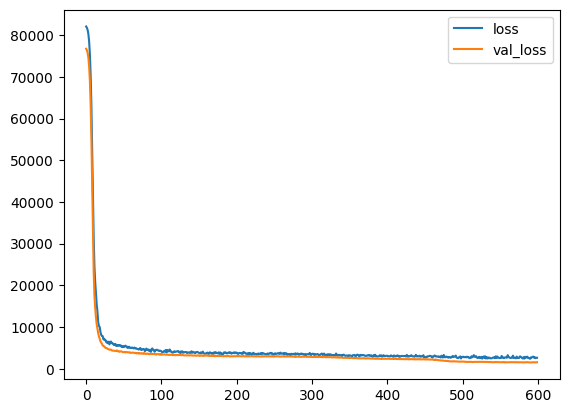

In [103]:
model.fit(x=X_train, y=y_train, epochs=600, validation_data=(X_val, y_val))

loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

Now I use the test data to see how well the model works. Using a scatter plot I compare the predicted values with the test values.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

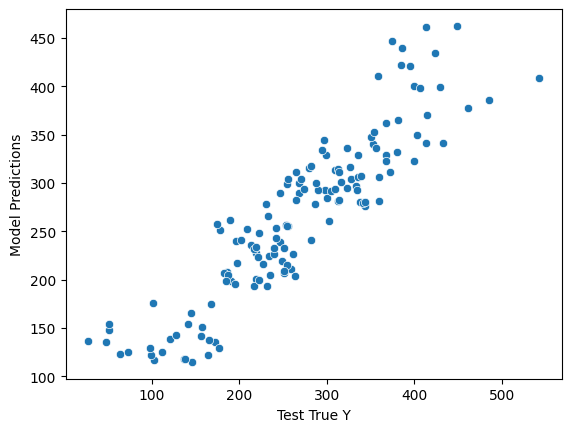

In [104]:
test_predictions = model.predict(X_test)

test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

pred_df
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

Then I visualize how well the prediction distribution follows the normal distribution.

C:\Users\zsolt\AppData\Local\Temp\ipykernel_21432\3264322254.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


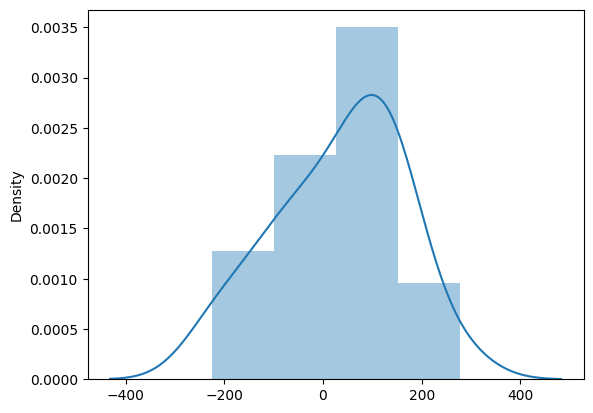

In [105]:
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

### Step 6: Metrics
Using some metrics, we can measure how well the model describes the original dataset.

In [106]:
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
33.6 $

MSE
1807.52 $^2

RMSE:
42.51 $

R-squared:
0.81

Explained variance score:
0.82


### Step 7: Using the model to predict with imaginary new values

In [107]:
tester_row = {
    'Number_of_Customers': 53,
    'Menu_Price': 33.25,
    'Marketing_Spend': 12.4,
    'Average_Customer_Spending': 15.5,
    'Promotions': 1,
    'Reviews': 40,
    'Cluster':0,
    # 'Cuisine_Type_American': 0,
    # 'Cuisine_Type_Italian': 1,
    # 'Cuisine_Type_Japanese': 0,
    # 'Cuisine_Type_Mexican': 0
}

tester_row = pd.DataFrame([tester_row])

result = model.predict(tester_row)[0]

print("\nEstimated restaurant revenue with the given numbers:")
print(f"$ {round(float(result[0]), 2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Estimated restaurant revenue with the given numbers:
$ 271.11


### Step 8: Conclusion
In my opinion, restaurant revenue can be influenced by many things, therefore it is hard to predict it exactly. (although this example contains data about average spending, nr. customers etc.) Because of that, I am satisfied with the results I got, I expected much worse. The results could be even more optimized if some of the unnecessary columns were removed.
This model could help restaurants to calculate their revenue for the next month based on the prevous ones.